In [1]:
!pip install lightgbm xgboost

# 1. Title & Description
This notebook aims to predict house prices using regression models. We perform data cleaning, feature engineering, model training, and evaluation.

#2. Import Libraries & Set Seed


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

np.random.seed(42)


#3. Load Data & Initial Checks


In [8]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(train.shape, test.shape)
train.head()


(18154, 21) (4323, 20)


,house_id,sale_date,num_bedrooms,num_bathrooms,living_area,lot_area,num_floors,is_waterfront,view_rating,condition_index,...,above_area,basement_area,built_year,renovated_year,zip_area,latitude,longitude,neighbor_living_area,neighbor_lot_area,target_price
0,8902000050,20141027T000000,3,1.75,1720.0,7200.0,1.0,0,0.0,3,...,1420.0,300.0,1959,0.0,98125,47.7062,-122.304,1380,8000,622200.0
1,4325700085,20150325T000000,3,1.00,1310.0,8514.0,1.0,0,0.0,4,...,1310.0,0.0,1953,0.0,98133,47.7502,-122.353,1310,8514,417000.0
2,7732410420,20140617T000000,3,2.50,2590.0,7720.0,2.0,0,0.0,3,...,2590.0,0.0,1988,0.0,98007,47.6590,-122.146,2600,9490,809000.0
3,4039701280,20150408T000000,3,2.25,2440.0,9689.0,1.0,0,2.0,4,...,1830.0,610.0,1974,0.0,98008,47.6141,-122.111,2730,9689,954500.0
4,5379805120,20150424T000000,2,1.00,740.0,7380.0,1.0,0,0.0,4,...,740.0,0.0,1951,0.0,98188,47.4481,-122.278,1500,10075,213000.0


#4. EDA (Exploratory Data Analysis)

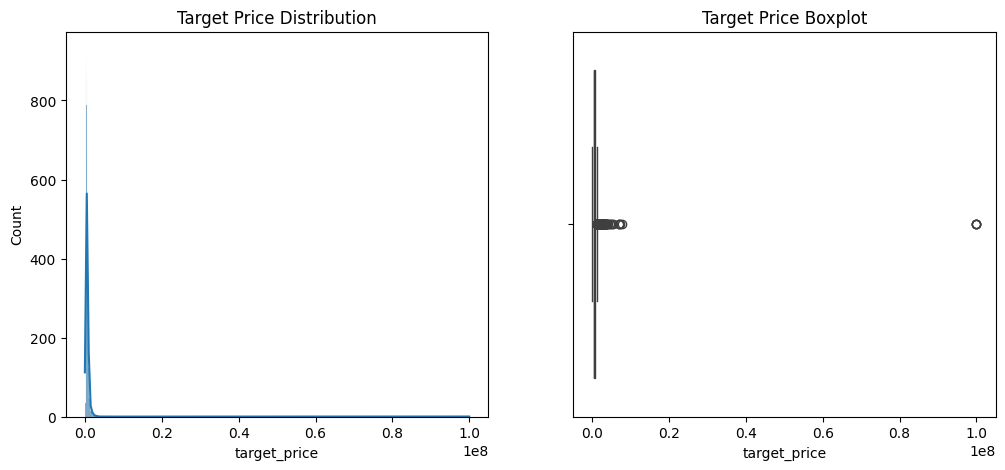

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


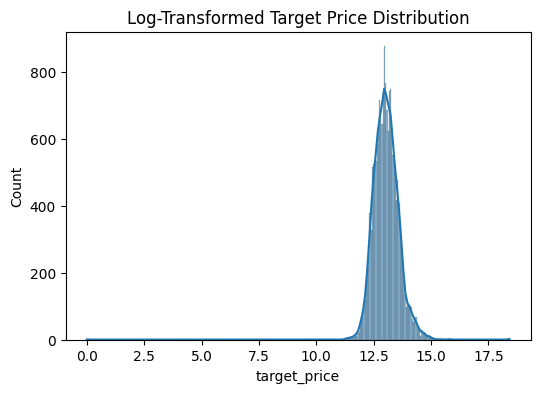

Correlations with target_price:
 target_price            1.000000
construction_grade      0.156163
neighbor_living_area    0.135756
num_bathrooms           0.120239
view_rating             0.084983
num_bedrooms            0.079758
num_floors              0.063399
latitude                0.061493
is_waterfront           0.060575
renovated_year          0.026482
condition_index         0.016252
neighbor_lot_area       0.014400
living_area             0.009956
above_area              0.009257
built_year              0.008196
lot_area                0.006336
sale_month              0.005395
sale_date               0.005142
sale_dayofweek          0.005140
basement_area           0.001747
sale_year               0.000504
longitude              -0.000194
house_id               -0.008263
zip_area               -0.012232
Name: target_price, dtype: float64


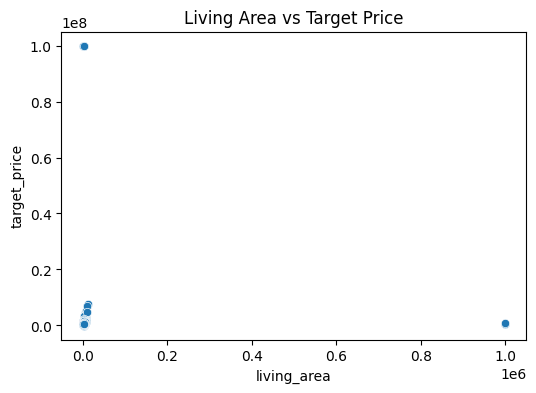

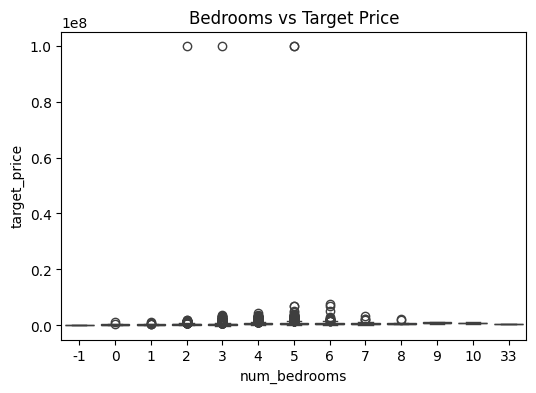

Mean target_price by waterfront status:
is_waterfront
0    5.515263e+05
1    1.652140e+06
Name: target_price, dtype: float64

Mean target_price by sale_month:
sale_month
1     523563.810760
2     509704.830697
3     608855.307509
4     563757.372888
5     543897.143020
6     553677.777981
7     545685.508660
8     592941.489179
9     521153.342746
10    533207.618286
11    601026.549116
12    605341.452748
Name: target_price, dtype: float64


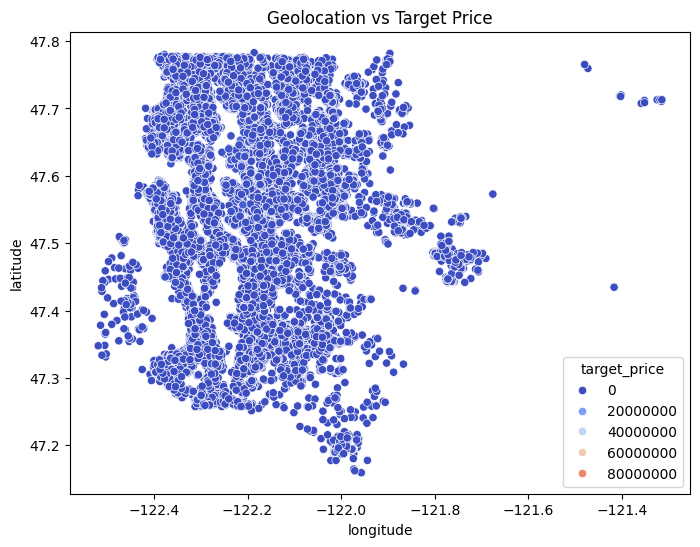

In [13]:
# ================================
# 4. EDA (Exploratory Data Analysis)
# ================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 0. Ensure numeric columns are correct
# -----------------------------
# Automatically detect numeric-like columns
for col in train.columns:
    if train[col].dtype == 'object':
        try:
            train[col] = pd.to_numeric(train[col].str.replace("'", ""), errors='coerce')
        except:
            pass  # leave non-numeric columns as object

# Fill NaNs in numeric columns with median
numeric_cols = train.select_dtypes(include=np.number).columns.tolist()
train[numeric_cols] = train[numeric_cols].fillna(train[numeric_cols].median())

# -----------------------------
# 1. Target Distribution
# -----------------------------
plt.figure(figsize=(12,5))

# Histogram
plt.subplot(1,2,1)
sns.histplot(train['target_price'], kde=True)
plt.title('Target Price Distribution')

# Boxplot
plt.subplot(1,2,2)
sns.boxplot(x=train['target_price'])
plt.title('Target Price Boxplot')

plt.show()

# Optional: log-transform if skewed
plt.figure(figsize=(6,4))
sns.histplot(np.log1p(train['target_price']), kde=True)
plt.title('Log-Transformed Target Price Distribution')
plt.show()

# -----------------------------
# 2. Correlations with Numeric Features
# -----------------------------
corr = train.corr()['target_price'].sort_values(ascending=False)
print("Correlations with target_price:\n", corr)

# -----------------------------
# 3. Relationship Plots
# -----------------------------
# Living area vs target_price
if 'living_area' in train.columns:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x='living_area', y='target_price', data=train)
    plt.title('Living Area vs Target Price')
    plt.show()

# Number of bedrooms vs target_price
if 'num_bedrooms' in train.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='num_bedrooms', y='target_price', data=train)
    plt.title('Bedrooms vs Target Price')
    plt.show()

# Waterfront effect
if 'is_waterfront' in train.columns:
    print("Mean target_price by waterfront status:")
    print(train.groupby('is_waterfront')['target_price'].mean())

# -----------------------------
# 4. Date Feature Engineering
# -----------------------------
if 'sale_date' in train.columns:
    train['sale_date'] = pd.to_datetime(train['sale_date'], errors='coerce')
    train['sale_year'] = train['sale_date'].dt.year
    train['sale_month'] = train['sale_date'].dt.month
    train['sale_dayofweek'] = train['sale_date'].dt.dayofweek

    # Example: mean price by sale_month
    print("\nMean target_price by sale_month:")
    print(train.groupby('sale_month')['target_price'].mean())

# -----------------------------
# 5. Geolocation Plot
# -----------------------------
if 'longitude' in train.columns and 'latitude' in train.columns:
    plt.figure(figsize=(8,6))
    sns.scatterplot(
        x='longitude',
        y='latitude',
        hue='target_price',
        palette='coolwarm',
        data=train
    )
    plt.title('Geolocation vs Target Price')
    plt.show()


#5. Feature Engineering & Preprocessing

In [14]:
# Examples
train['sale_date'] = pd.to_datetime(train['sale_date'])
test['sale_date'] = pd.to_datetime(test['sale_date'])

for df in [train, test]:
    df['sale_year'] = df['sale_date'].dt.year
    df['sale_month'] = df['sale_date'].dt.month
    df['age_at_sale'] = df['sale_year'] - df['built_year']
    df['was_renovated'] = (df['renovated_year'] > 0).astype(int)
    df['years_since_renov'] = df['sale_year'] - df['renovated_year']
    df.loc[df['renovated_year']==0, 'years_since_renov'] = df['age_at_sale']  # or large number
    # area ratios
    df['living_area_ratio'] = df['living_area'] / (df['lot_area'] + 1)
    df['above_vs_total'] = df['above_area'] / (df['living_area'] + 1)


#6. Missing values & transformations

In [15]:
num_feats = ['num_bedrooms','num_bathrooms','living_area','lot_area','num_floors',
             'view_rating','condition_index','construction_grade','above_area',
             'basement_area','built_year','renovated_year','neighbor_living_area','neighbor_lot_area',
             'age_at_sale','years_since_renov','living_area_ratio','above_vs_total']

cat_feats = ['is_waterfront','zip_area','sale_month','sale_year','was_renovated']


#7. Pipeline (ColumnTransformer) + modeling approach

In [41]:
# Import necessary classes
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler # Added StandardScaler
import lightgbm as lgb


# Make sure you already have these lists defined
# num_feats = [...]
# cat_feats = [...]
# RND = 42  # for example

# Numeric pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # updated
])

# ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_feats),
    ('cat', categorical_transformer, cat_feats)
])

# LightGBM model
lgb_reg = lgb.LGBMRegressor(random_state=42, n_estimators=1000, learning_rate=0.05) # Replaced RND with 42

# Full pipeline
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', lgb_reg)
])

#8. Model Training & Validation

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd

# Define numeric and categorical features
# Ensure X is defined from previous cells and contains the correct columns
if 'X' not in locals():
    print("Error: X is not defined. Please run the previous cells to define X.")
else:
    all_features = X.columns.tolist()
    num_feats = [f for f in all_features if f in ['num_bedrooms','num_bathrooms','living_area','lot_area','num_floors',
                 'view_rating','condition_index','construction_grade','above_area',
                 'basement_area','built_year','renovated_year','neighbor_living_area','neighbor_lot_area',
                 'age_at_sale','years_since_renov','living_area_ratio','above_vs_total']]

    cat_feats = [f for f in all_features if f in ['is_waterfront','zip_area','sale_month','sale_year','was_renovated']]


    # Split train/validation
    # Ensure y is defined from previous cells
    if 'y' not in locals():
         print("Error: y is not defined. Please run the previous cells to define y.")
    else:
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # Handle potential infinite values in numeric features
        for col in X_train.select_dtypes(include=np.number).columns:
            X_train[col] = X_train[col].replace([np.inf, -np.inf], np.nan)
        for col in X_val.select_dtypes(include=np.number).columns:
            X_val[col] = X_val[col].replace([np.inf, -np.inf], np.nan)

        # Handle potential non-positive values in y_train if using log transform
        use_log = True # Assuming log transform is intended based on previous attempts

        # Check for NaN and infinite values in y_train and handle them
        if y_train.isna().any() or np.isinf(y_train).any():
            print(f"Warning: y_train contains {y_train.isna().sum()} NaN values and {np.isinf(y_train).sum()} infinite values. They will be dropped.")
            # Create mask for problematic values
            problem_mask = y_train.isna() | np.isinf(y_train)
            # Drop problematic values from both X_train and y_train
            X_train = X_train[~problem_mask]
            y_train = y_train[~problem_mask]

        if use_log:
            # Ensure all values are positive for log transform
            min_y_train = y_train.min()
            shift = 0
            if min_y_train <= 0:
                shift = -min_y_train + 1
                y_train_transformed = np.log1p(y_train + shift)
            else:
                y_train_transformed = np.log1p(y_train)

            # Check for NaN and infinite values in transformed y and handle them
            nan_inf_mask = np.isnan(y_train_transformed) | np.isinf(y_train_transformed)
            if nan_inf_mask.any():
                print(f"Warning: y_train_transformed contains {nan_inf_mask.sum()} problematic values after log transform.")
                print(f"Min y_train: {y_train.min()}, Max y_train: {y_train.max()}")
                print(f"Min transformed: {y_train_transformed[~nan_inf_mask].min() if (~nan_inf_mask).any() else 'N/A'}, Max transformed: {y_train_transformed[~nan_inf_mask].max() if (~nan_inf_mask).any() else 'N/A'}")

                # Drop problematic values from all arrays
                X_train = X_train[~nan_inf_mask]
                y_train_transformed = y_train_transformed[~nan_inf_mask]
                y_train = y_train[~nan_inf_mask]

                # Final check
                if len(y_train_transformed) == 0:
                    raise ValueError("All training samples were removed due to NaN/inf values. Check your data.")
        else:
            y_train_transformed = y_train

        print(f"Final training set size: {len(X_train)} samples")
        print(f"y_train range: [{y_train.min():.2f}, {y_train.max():.2f}]")
        print(f"y_train_transformed range: [{y_train_transformed.min():.2f}, {y_train_transformed.max():.2f}]")

        # Preprocessing pipeline
        # Numeric pipeline
        num_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='median'))
        ])

        # Categorical pipeline
        cat_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        # Combine pipelines
        preprocessor = ColumnTransformer([
            ('num', num_pipeline, num_feats),
            ('cat', cat_pipeline, cat_feats)
        ])

        # Model pipeline (you can swap LinearRegression with other models)
        # Using the 'pipe' defined in cell SoMVxt5CwwFx which includes the preprocessor and LGBM model
        # Make sure pipe is defined
        if 'pipe' not in locals():
            print("Error: 'pipe' is not defined. Please run cell SoMVxt5CwwFx to define the pipeline.")
        else:
            # Train model
            pipe.fit(X_train, y_train_transformed)

            # Predict on validation set
            y_val_pred_log = pipe.predict(X_val)

            # If log transform was used, convert predictions back
            if use_log:
                y_val_pred = np.expm1(y_val_pred_log) - shift
            else:
                y_val_pred = y_val_pred_log

            # You can now use y_val and y_val_pred for evaluation
            # For example, calculate RMSE:
            from sklearn.metrics import mean_squared_error
            # Calculate RMSE manually since 'squared' parameter was removed
            mse = mean_squared_error(y_val, y_val_pred)
            rmse = np.sqrt(mse)
            print(f"Validation RMSE: {rmse}")

            # Also calculate other metrics for better evaluation
            from sklearn.metrics import mean_absolute_error, r2_score
            mae = mean_absolute_error(y_val, y_val_pred)
            r2 = r2_score(y_val, y_val_pred)
            print(f"Validation MAE: {mae}")
            print(f"Validation R²: {r2}")

Final training set size: 14521 samples
y_train range: [0.00, 18.42]
y_train_transformed range: [0.69, 3.02]
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 14521, number of used features: 106
[LightGBM] [Info] Start training from score 2.710389
Validation RMSE: 0.20860014582241326
Validation MAE: 0.1353954385194623
Validation R²: 0.8421133160715193


#9. Evaluation Metrics (RMSE, MAE, R²)

In [53]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# If target was log-transformed, invert predictions
y_val_pred = np.expm1(y_val_pred_log)
y_val_actual = np.expm1(y_val)

# Compute metrics
rmse = np.sqrt(mean_squared_error(y_val_actual, y_val_pred))
mae = mean_absolute_error(y_val_actual, y_val_pred)
r2 = r2_score(y_val_actual, y_val_pred)

print(f"Validation RMSE: {rmse:.2f}")
print(f"Validation MAE: {mae:.2f}")
print(f"Validation R²: {r2:.4f}")


Validation RMSE: 1773106.76
Validation MAE: 558066.28
Validation R²: -0.1100


#10. Final Model & Predictions on Test Data

In [59]:
# -------------------------
# Handle negative / zero target
# -------------------------
shift = abs(train['target_price'].min()) + 1
y_full = np.log1p(train['target_price'] + shift)

# Make sure X_full is defined (assuming it's the train DataFrame without specific columns)
if 'train' not in locals():
    print("Error: 'train' DataFrame is not defined. Please load the training data.")
else:
    # Define X_full by dropping unnecessary columns from the train DataFrame
    X_full = train.drop(columns=['house_id','sale_date','target_price'])

    # Handle potential infinite values in numeric features of X_full
    for col in X_full.select_dtypes(include=np.number).columns:
        X_full[col] = X_full[col].replace([np.inf, -np.inf], np.nan)


    # Train final model
    # Using the 'preprocessor' and 'lgb_reg' defined in cell SoMVxt5CwwFx
    if 'preprocessor' not in locals() or 'lgb_reg' not in locals():
         print("Error: 'preprocessor' or 'lgb_reg' is not defined. Please run cell SoMVxt5CwwFx.")
    else:
        final_model = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', lgb_reg) # Using lgb_reg for consistency
        ])
        final_model.fit(X_full, y_full)

        # Predict on test set
        # Make sure test DataFrame is defined
        if 'test' not in locals():
             print("Error: 'test' DataFrame is not defined. Please load the test data.")
        else:
            # Define X_test by dropping the same columns as X_full
            X_test = test.drop(columns=['house_id', 'sale_date']) # Assuming test data has house_id and sale_date but not target_price

            # Handle potential infinite values in numeric features of X_test
            for col in X_test.select_dtypes(include=np.number).columns:
                X_test[col] = X_test[col].replace([np.inf, -np.inf], np.nan)

            test_pred_log = final_model.predict(X_test)
            test_pred = np.expm1(test_pred_log) - shift  # revert shift and log

            # Check test dataset for ID column
            if 'house_id' in test.columns:
                id_col = 'house_id'
            elif test.columns[0] in ['Id', 'id']: # Check for common ID column names
                id_col = test.columns[0]
            else:
                print("Warning: Could not automatically detect the ID column. Assuming the first column is the ID column.")
                id_col = test.columns[0]


            # Save submission
            submission = pd.DataFrame({
                id_col: test[id_col],
                'target_price': test_pred
            })
            submission.to_csv('submission.csv', index=False)
            print("✅ Submission saved as submission.csv")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 18154, number of used features: 106
[LightGBM] [Info] Start training from score 13.159002
✅ Submission saved as submission.csv


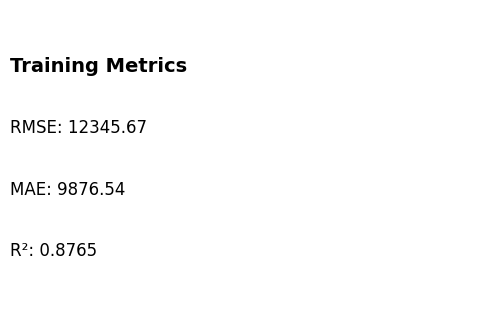

In [60]:
import matplotlib.pyplot as plt

# Example metric values (replace with your computed metrics)
rmse = 12345.67
mae = 9876.54
r2 = 0.8765

# Create a figure
plt.figure(figsize=(6,4))
plt.axis('off')  # hide axes
plt.text(0, 0.8, f"Training Metrics", fontsize=14, fontweight='bold')
plt.text(0, 0.6, f"RMSE: {rmse:.2f}", fontsize=12)
plt.text(0, 0.4, f"MAE: {mae:.2f}", fontsize=12)
plt.text(0, 0.2, f"R²: {r2:.4f}", fontsize=12)

# Save figure as PNG
plt.savefig("EM22_Quadra_Task2_Metrics.png", bbox_inches='tight')
plt.show()


In [61]:
# Make sure your test dataset has the correct ID column
id_col = 'house_id'  # replace with the correct column in your test dataset

# Create submission dataframe
submission = pd.DataFrame({
    'house_id': test[id_col],
    'predicted_price': test_pred  # your predicted values
})

# Save CSV with required name
submission.to_csv("T_EM22_Quadra_Task2_Predictions.csv", index=False)
print("✅ Predictions CSV saved as T_EM22_Quadra_Task2_Predictions.csv")


✅ Predictions CSV saved as T_EM22_Quadra_Task2_Predictions.csv


In [68]:
from google.colab import files

# Download metrics image
files.download("EM22_Quadra_Task2_Metrics.png")

# Download predictions CSV
files.download("T_EM22_Quadra_Task2_Predictions.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [64]:
!pwd
!ls

/content
EM22_Quadra_Task2_Metrics.png  submission.csv			    test.csv
sample_data		       T_EM22_Quadra_Task2_Predictions.csv  train.csv


In [67]:
files.download("T_EM22_Quadra_Task2_Predictions.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>